In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics

### Univariate Gaussian Generator ###
The algorithms listed below all generate the standard normal deviates, since a N(μ, σ2) can be generated as X = μ + σZ, where Z is standard normal.

An easy to program approximate approach, that relies on the central limit theorem, is as follows: generate 12 uniform U(0,1) deviates, add them all up, and subtract 6 – the resulting random variable will have approximately standard normal distribution. In truth, the distribution will be Irwin–Hall, which is a 12-section eleventh-order polynomial approximation to the normal distribution. This random deviate will have a limited range of (−6, 6)

cited from : https://en.wikipedia.org/wiki/Normal_distribution#Generating_values_from_normal_distribution

In [4]:
def UnivariateGaussianDataGenerator(mean, variance):
    z = np.sum(np.random.uniform(0.0, 1.0, 12))-6
    sample = mean + np.math.sqrt(variance) * z
    return sample

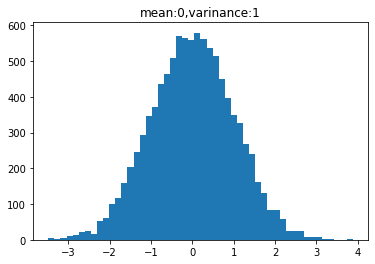

In [5]:
#check
mean=0
variance=1
nData=10000
nBin=50
sample=[]
for i in range(nData):
    sample.append(UnivariateGaussianDataGenerator(mean, variance))
plt.hist(sample,int(nBin)) #can't use plt.plot(sample), because plot's x coordinate is according to the coming data's time; but actually we want to count the amount of each sample's value
plt.title("mean:{},varinance:{}".format(mean,variance))
plt.show()

### Polynomial basis linear model data generator ###
input : $n$(basis number), $a$(variance), $\vec w$(coefficients)=$\begin{bmatrix} w_{nBasis-1} \\ \vdots \\ w_1 \\ w_0 \end{bmatrix}$

output : $y$

where $y=w_0*x^0+w_1*x^1+$...$+w_n*x^n+e$ , 

$e$ follows $N(0,a)$

$x_i$ is uniformly distributed between $(-1,1)$,

In [6]:
def PolynomialBasisLinearModelDataGenerator(nBasis,a,vec_w):
    x=np.random.uniform(-1.0, 1.0)
    e=UnivariateGaussianDataGenerator(0,a)
    y=0
    for i in range(nBasis):
        y+=vec_w[i].item()*math.pow(x,nBasis-i-1)
    y+=e
    return (x,y)

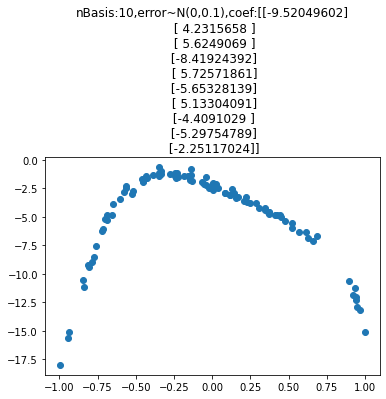

In [7]:
#check
nData=100
nBasis=10  #basis number
a=0.1 #variance of N(0,a)
vec_w=np.random.uniform(-10.0,10.0,nBasis).reshape(-1,1)#coefficients

sampleX=[]
sampleY=[]
for i in range(nData):
    (x,y)=PolynomialBasisLinearModelDataGenerator(nBasis,a,vec_w)
    sampleX.append(x)
    sampleY.append(y)
plt.scatter(sampleX,sampleY)
plt.title("nBasis:{},error~N(0,{}),coef:{}".format(nBasis,a,vec_w))
plt.show()

### Sequential Estimator ###
input: mean $m$, variance $s$ 

output: print the new data point and the current estimiates of $(m,s)$ of and in each iteration

note: call (1.a)univariate gaussain data generator to get a new data point from

note: use sequential estimation to find the current estimates to $m$ and $s$ by deriving the recursive function of $m$ and $s$

$$
\begin{align}
\bar x_n&=\frac{1}{n}\sum_{i=1}^nx_i=mean_{MLE,n} \\
\bar x_{n+1}&=\frac{1}{n+1}\sum_{i=1}^{n+1}x_i \\
&=\frac{n}{n+1}*\frac{1}{n}\sum_{i=1}^nx_i+\frac{x_{n+1}}{n+1} \\
&=\frac{n}{n+1}*\bar x_n+\frac{x_{n+1}}{n+1}=\bar x_n+\frac{x_{n+1}-\bar x_n}{n+1}
\\\\
s_n&=\frac{1}{n}\sum_{i=1}^n(x_i-\bar x_n)^2=variance_{MLE,n} \\
s_{n+1}&=\frac{1}{n+1}\sum_{i=1}^{n+1}(x_i-\bar x_{n+1})^2 \\
&=\frac{n}{n+1}*\frac{1}{n}\sum_{i=1}^{n}(x_i-\bar x_{n+1})^2+\frac{1}{n+1}(x_{n+1}-\bar x_{n+1})^2 \\
&=\frac{n}{n+1}*\frac{1}{n}\sum_{i=1}^{n}(x_i-\bar x_n-\frac{x_{n+1}-\bar x_n}{n+1})^2+\frac{1}{n+1}(x_{n+1}-\bar x_{n+1})^2 \\
&=\frac{n}{n+1}*\frac{1}{n}\sum_{i=1}^{n}[(x_i-\bar x_n)^2-2(x_i-\bar x_n)(\frac{x_{n+1}-\bar x_n}{n+1})+(\frac{x_{n+1}-\bar x_n}{n+1})^2]+\frac{1}{n+1}(x_{n+1}-\bar x_{n+1})^2 \\
&=\frac{n}{n+1}*\frac{1}{n}\sum_{i=1}^{n}(x_i-\bar x_n)^2-\frac{2}{n}\sum_{i=1}^{n}(x_i-\bar x_n)(\frac{x_{n+1}-\bar x_n}{n+1})+\frac{1}{n}\sum_{i=1}^{n}(\frac{x_{n+1}-\bar x_n}{n+1})^2+\frac{1}{n+1}(x_{n+1}-\bar x_{n+1})^2  \\
&=\frac{n}{n+1}s_n-\frac{2}{n}\sum_{i=1}^{n}(x_i-\bar x_n)(\frac{x_{n+1}-\bar x_n}{n+1})+(\frac{x_{n+1}-\bar x_n}{n+1})^2+\frac{1}{n+1}(x_{n+1}-\bar x_{n+1})^2 \\
&=\frac{n-1}{n}s_n+\frac{1}{n+1}(x_{n+1}-\bar x_n)^2 \\
\end{align}
$$

In [8]:
def SequentialEstimator(mean,variance,eps):
    mle_mean0=0.0
    mle_variance0=0.0
    n=0
    datas=[]
    while True:
        data=UnivariateGaussianDataGenerator(mean, variance)
        datas.append(data)
        mle_mean1=(n*mle_mean0+data)/(n+1)
        mle_variance1=0 if n==0 else (n-1)*mle_variance0/n+(data-mle_mean0)**2/(n+1)
        if abs(mle_mean1 - mle_mean0) < eps and abs(mle_variance1 - mle_variance0) < eps:
            break
        print('Add data point: {}'.format(data))
        print('Mean={}  Variance={}'.format(mle_mean1,mle_variance1))
        #if(n!=0): print('ansMean={}  ansVariance={}'.format(statistics.mean(datas),statistics.variance(datas)))
        print()
        mle_mean0=mle_mean1
        mle_variance0=mle_variance1
        n+=1
    

In [9]:
#implement SequentialEstimator
if __name__=='__main__':
    mean=0
    variance=1
    eps=1e-3
    SequentialEstimator(mean,variance,eps)

Add data point: 1.7654345966457958
Mean=1.7654345966457958  Variance=0

Add data point: -0.16416905845237473
Mean=0.8006327690967106  Variance=1.8616851328841098

Add data point: 0.3146333941665542
Mean=0.6386329774533251  Variance=1.0095743639195558

Add data point: 1.7845366856040465
Mean=0.9251089044910055  Variance=1.001323403034764

Add data point: 0.33935104495012425
Mean=0.8079573325828292  Variance=0.819615006278856

Add data point: 1.1418459369912375
Mean=0.8636054333175639  Variance=0.6742722717153838

Add data point: 2.0851889900872447
Mean=1.038117369998947  Variance=0.7750744720728291

Add data point: 0.7279733540973945
Mean=0.999349368011253  Variance=0.6763732113159392

Add data point: 0.247016311239312
Mean=0.9157568061477038  Variance=0.6547160074916483

Add data point: -0.38778681892728706
Mean=0.7854024436402047  Variance=0.7518923826843855

Add data point: -1.0114822390702436
Mean=0.6220492906665277  Variance=0.9702299228668041

Add data point: -0.8563715332546744
M

### Baysian Linear regression ###
1.demo的時候要注意一點，左下角本來就只有10個點，所以難免會跟作業3的檔案的左下角圖長得不一樣，當資料增加之後，這個誤差就會越來越小了

2.再來作業3的檔案的左下跟右下的圖x比例尺根本不是[-2,-1,0,1,2]，而大約是[-1.85,-1,0,1,1.85]，所以用x=-2的邊界來看對不對本身就有問題...

given data $A=\begin{bmatrix}x_1^{nBasis-1}&...&x_1^2&x_1&1\\x_2^{nBasis-1}&...&x_2^2&x_2&1 \\ \vdots&\vdots&\vdots&\vdots&\vdots \\ x_{nData}^{nBasis-1}&...&x_{nData}^2&x_{nData}&1\end{bmatrix},\vec b=\begin{bmatrix}y_1\\y_2\\\vdots\\y_{nData}\end{bmatrix}$



likelihood $y_i \sim ^{iid}N^{univariate}(y|A\vec x,a^{-1}),a$ is a fixed number, $\vec x$ is defined below as coefficients



assume posterior/prior $\vec x=\begin{bmatrix}w_{nBasis-1}\\\vdots\\w_1\\w_0\end{bmatrix} \sim N^{multivariate}(\vec x|\vec 0,b^{-1}I),b$ is a fixed number
$$
\begin{aligned}
\rightarrow&
\left\{
\begin{aligned}
\vec \mu_{current} &= (A^TA+\frac{b}{a}I)^{-1}A^T\vec b=a\Gamma^{-1}_{current}A^T\vec b \\
\Gamma_{current} &= aA^TA+bI
\end{aligned}
\right. \\
\rightarrow& N^{multivariate}(\vec x|\vec \mu_{current},\Gamma^{-1}_{current}) \\
\rightarrow&
\left\{
\begin{aligned}
\vec \mu_{current} &= \Gamma^{-1}_{current}(\Gamma_{last}\vec \mu_{last}+aA^T\vec b) \\
\Gamma_{current} &= aA^TA+\Gamma_{last}
\end{aligned}
\right.
\end{aligned}
$$


predictive distribution $P(y|D)=\int [P(y|\vec x,D)*P(\vec x|D)]d\vec x = \int [N(y|A\vec x,a^{-1})N(\vec x|\vec \mu_{current},\Gamma^{-1}_{current})]d\vec x \sim N(y|\vec m',(C')^{-1})$
$$
\left\{
\begin{aligned}
\vec m' &= A\vec \mu_{current}\\
C' &= a^{-1}+A\Gamma^{-1}_{current}A^T
\end{aligned}
\right.
$$

In [10]:
def visualization(vec_u1,gamma1,datas,i,bayesianParameter,groundTruthParameter,visualParameter):
    #assign parameter
    (_,nDataT)=bayesianParameter
    (nDataV,fig,axs)=visualParameter
    (nBasis,a,vec_w)=groundTruthParameter
    
    #drawing
    visual_x=np.linspace(-2,2,nDataV)
    visual_A=np.array([np.power(visual_x,i) for i in reversed(range(nBasis))]).T
    visual_y_mean_estimate=visual_A@vec_u1
    visual_y_variance_estimate=(a**-1)+visual_A@np.linalg.inv(gamma1)@visual_A.T
    if i==9:
        #After 10 incomes
        axs[1,0].set_title("After 10 incomes")
        axs[1,0].scatter(datas[:10,0],datas[:10,1])
        axs[1,0].plot(visual_x,visual_y_mean_estimate,'k-')
        axs[1,0].plot(visual_x,visual_y_mean_estimate+np.diagonal(visual_y_variance_estimate).reshape(-1,1),'r-')#only want to pick single data's variance,not two data's covariance
        axs[1,0].plot(visual_x,visual_y_mean_estimate-np.diagonal(visual_y_variance_estimate).reshape(-1,1),'r-')
    
    if i==49:
        #After 50 incomes
        axs[1,1].set_title("After 50 incomes")
        axs[1,1].scatter(datas[:50,0],datas[:50,1])
        axs[1,1].plot(visual_x,visual_y_mean_estimate,'k-')
        axs[1,1].plot(visual_x,visual_y_mean_estimate+np.diagonal(visual_y_variance_estimate).reshape(-1,1),'r-')
        axs[1,1].plot(visual_x,visual_y_mean_estimate-np.diagonal(visual_y_variance_estimate).reshape(-1,1),'r-')

    if i==(nDataT-1):
        #Ground truth
        visual_y_mean_true=visual_A@vec_w
        visual_y_variance_true=(1/a)*np.identity(nData)
        axs[0,0].set_title("Ground truth")
        axs[0,0].plot(visual_x,visual_y_mean_true,'k-')
        axs[0,0].plot(visual_x,visual_y_mean_true+np.diagonal(visual_y_variance_true).reshape(-1,1),'r-')
        axs[0,0].plot(visual_x,visual_y_mean_true-np.diagonal(visual_y_variance_true).reshape(-1,1),'r-')

        #Predict result
        axs[0,1].set_title("Predict result (After {} incomes)".format(nDataT))
        axs[0,1].scatter(datas[:,0],datas[:,1])
        axs[0,1].plot(visual_x,visual_y_mean_estimate,'k-')
        axs[0,1].plot(visual_x,visual_y_mean_estimate+np.diagonal(visual_y_variance_estimate).reshape(-1,1),'r-')
        axs[0,1].plot(visual_x,visual_y_mean_estimate-np.diagonal(visual_y_variance_estimate).reshape(-1,1),'r-')


In [11]:
def BayesianLinearRegression(bayesianParameter,groundTruthParameter,visualParameter):
    #assign parameter
    (b,nDataT)=bayesianParameter
    (nDataV,fig,axs)=visualParameter
    (nBasis,a,vec_w)=groundTruthParameter
    
    #initialize bayesian linear regression's parameters
    vec_u0=np.zeros((nBasis,1))
    gamma0=np.linalg.inv(b**(-1)*np.identity(nBasis))
    a=1/a #transform variance to precision of ground truth's error
    groundTruthParameter=(nBasis,a,vec_w)

    for i in range(nDataT):
        #add data point
        data=PolynomialBasisLinearModelDataGenerator(nBasis,1/a,vec_w)
        datas=data if i==0 else np.vstack((datas,data))
        A=np.array([[math.pow(data[0],i) for i in reversed(range(nBasis))]])
        #A=np.array([[math.pow(data[j,0],i) for i in reversed(range(nBasis)) ]for j in range(nData)])
        vec_b=np.array([[data[1]]])
        print('Add data point {}:'.format(data),end="\n\n")

        #computer posterior's mean and precision 
        gamma1=a*A.T@A+gamma0
        vec_u1=np.linalg.inv(gamma1)@(gamma0@vec_u0+a*A.T@vec_b)
        print('Posterior mean: \n',vec_u1,end="\n\n")
        print('Posterior variance: \n',np.linalg.inv(gamma1),end="\n\n")

        #predictive distribution
        vec_m=A@vec_u1
        C=(a**-1)+A@np.linalg.inv(gamma1)@A.T
        print('Predictive distribution ~ N({},{})'.format(vec_m.item(),C.item()))
        print('--------------------------------------------------')
        
        #visualization
        if i==9 or i==49 or i==nDataT-1:#when we've add i-th data
            visualization(vec_u1,gamma1,datas,i,bayesianParameter,groundTruthParameter,visualParameter)
        
        #transform prior as posterior
        gamma0=gamma1
        vec_u0=vec_u1


b:  1


Add data point (0.2759028449707772, 1.9812097429889355):

Posterior mean: 
 [[0.01998221]
 [0.07242482]
 [0.26250115]
 [0.95142605]]

Posterior variance: 
 [[ 9.99788173e-01 -7.67759993e-04 -2.78271865e-03 -1.00858643e-02]
 [-7.67759993e-04  9.97217281e-01 -1.00858643e-02 -3.65558546e-02]
 [-2.78271865e-03 -1.00858643e-02  9.63444145e-01 -1.32495388e-01]
 [-1.00858643e-02 -3.65558546e-02 -1.32495388e-01  5.19775200e-01]]

Predictive distribution ~ N(1.0297836908465612,1.5197752002233678)
--------------------------------------------------
Add data point (0.08987422505599785, 1.2999778577749166):

Posterior mean: 
 [[0.01790718]
 [0.06607911]
 [0.25257734]
 [1.06094922]]

Posterior variance: 
 [[ 9.99726654e-01 -9.55892182e-04 -3.07693188e-03 -6.83881091e-03]
 [-9.55892182e-04  9.96641951e-01 -1.09856027e-02 -2.66259859e-02]
 [-3.07693188e-03 -1.09856027e-02  9.62037076e-01 -1.16966420e-01]
 [-6.83881091e-03 -2.66259859e-02 -1.16966420e-01  3.48391377e-01]]

Predictive distribution ~ N(1

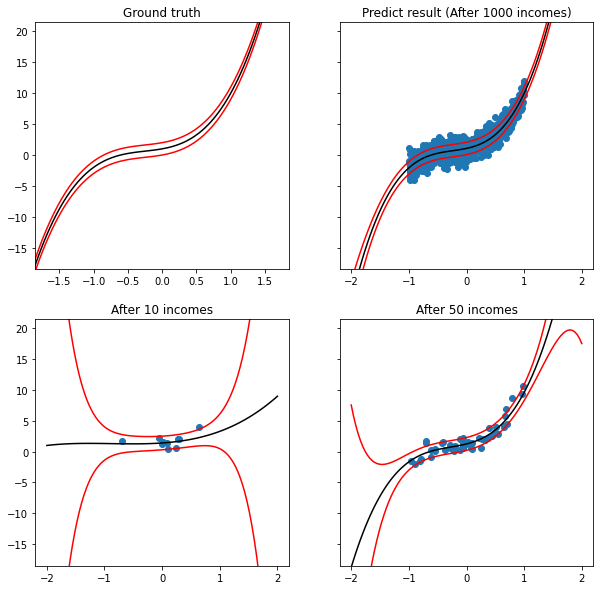

In [12]:
#implement BayesianLinearRegression
if __name__=='__main__':
    #input and build bayesian parameter
    b = int(input("b: ")) #precision of initial prior 
    nDataT=1000 #for times of adding data
    bayesianParameter=(b,nDataT)

    #build visual parameter
    nDataV=100 #for visualization
    fig, axs = plt.subplots(2, 2, figsize=(10,10),sharey=True)
    visualParameter=(nDataV,fig,axs)
    axs[0,0].set_ylim(-18.5,21.5)
    axs[0,0].set_xlim(-1.85,1.85)

    #build the ground truth paramter
    nBasis = 4 #number of basis
    a = 1 #varaicne of ground truth's error
    vec_w = np.array([4,3,2,1]).reshape(-1,1)#np.random.uniform(-10.0,10.0,nBasis).reshape(-1,1) #coefficients of ground truth
    groundTruthParameter=(nBasis,a,vec_w)
    BayesianLinearRegression(bayesianParameter,groundTruthParameter,visualParameter)